In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Nice graphics
plt.style.use('ggplot')

In [18]:
#Prend un élément au hasard dans une liste
def pick_random_list(l):
    return l[np.random.randint(0,len(l))]

In [19]:
#Extrait n lignes aléatoires d'un array avec remise
def pick_random(X, n = 1):
    return X[np.random.randint(0,len(X), n)]

In [20]:
def build_maae(l_max = 100, d = 2):
    """
        Build an MAAE (no length fixed, can sometimes be blocked before finishing)
    """    
    
    m, p = [[0]*d], 1.0
    directions = np.concatenate((np.identity(d), -np.identity(d))).astype(np.int8) #possibités de déplacement sans contraintes
    for l in range(l_max):
        last_pos = m[len(m) - 1]
        new_pos = last_pos + directions
        
        # Checking position
        pos_available = []
        for pos in new_pos.tolist():
            if pos not in m:
                pos_available.append(pos)
        
        #Handling proba
        n_pos = len(pos_available)
        if (n_pos == 0):
            break
        else:
            p *= 1/float(n_pos)
        
        # Picking random one
        next_pos = pick_random_list(pos_available)
        m.append(next_pos)
    
    return np.array(m), p

In [21]:
def build_maae_l(l, d = 2, iter_max=1000):
    """
        Build an MAAE with a fixed length
        returns the walk, its probability and the selection frequency of the process
    """    
    
    for i in range(iter_max):
        m, p = build_maae(l_max = l, d = d)
        if (len(m) == l+1):
            return m, p, float(1)/float((i+1))
    raise ValueError(str(l) + " length is too far to reach in " + str(d) +" dimension. ("+str(iter_max)+" iterations)")

In [22]:
def dist(m):
    """
        Give the euclidian distance of a walk
    """
    return np.linalg.norm(m[0]-m[len(m) - 1])

In [23]:
def plot(m):
    """
        Plot a walk
    """
    plt.figure()
    plt.grid()
    plt.axis("equal")
    plt.plot(m[:,0], m[:,1])

## Check for symetry

<IPython.core.display.Javascript object>


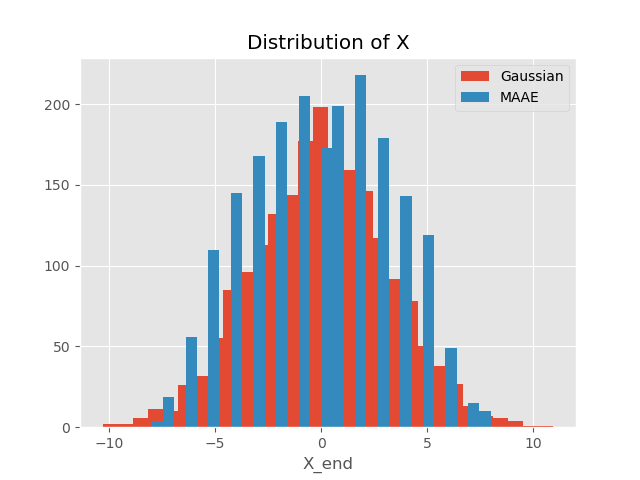

<IPython.core.display.Javascript object>


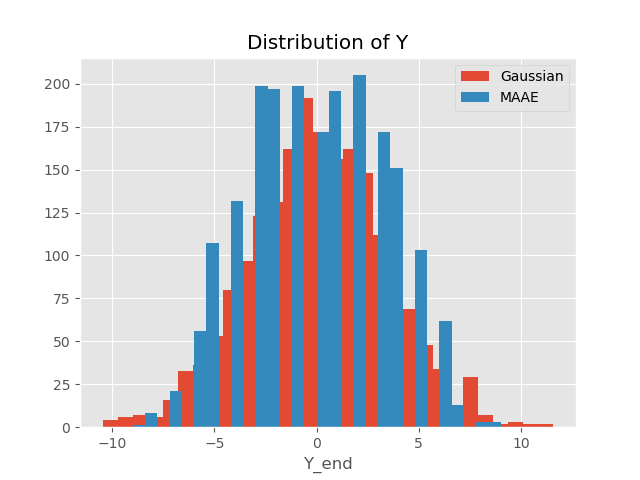

In [37]:
#Check for the symetry of the self avoiding walks

# Generate n walk and store the arrival
n = 2000
end_points = np.zeros((n,2))
for i in range(n):
    m, _, _ = build_maae_l(10, d = 2, iter_max=1000)
    end_points[i] = m[len(m) - 1]
X, Y = end_points[:, 0], end_points[:, 1]
    
mean_X = np.mean(X)
std_X = np.std(X)

mean_Y = np.mean(Y)
std_Y = np.std(Y)

#Comparition with a guaussian distribution

bins = 30

plt.figure()
plt.title("Distribution of X")
plt.xlabel("X_end")
plt.hist(np.random.randn(n)*std_X, bins, label="Gaussian")
plt.hist(X, bins, label = "MAAE")
plt.legend()

plt.figure()
plt.title("Distribution of Y")
plt.xlabel("Y_end")
plt.hist(np.random.randn(n)*std_Y, bins, label = "Gaussian")
plt.hist(Y, bins, label = "MAAE")
plt.legend()

# Estimators

In [38]:
import time

In [53]:
def mean_d_IS(l, n = 10000):
    """
        Estimator of the mean distance of a MAAE
        with Importance Sampling
    """
    
    D = np.zeros(n)
    S = np.zeros(n)
    for i in range(n):
        m, p, accept_rate = build_maae_l(l)
        D[i] = dist(m)
        S[i] = 1/p
    
    estimated_average_distance = np.sum(D*S)/np.sum(S)
    estimated_variance = (n*np.sum(np.square(S)*np.square(D-estimated_average_distance)))/(np.sum(S))**2
    
    return  estimated_average_distance, estimated_variance

In [64]:
def plot_estimator(estimator, l_max, l_min = 2, n = 10000):
    """
        Plot estimator result with its error 
    """
    
    L = range(l_min, l_max)
    n_L = len(L)

    D = np.zeros(n_L) # Estimator result
    V = np.zeros(n_L) # Variance

    for i, l in enumerate(L):
        distance, var = estimator(l, n)
        D[i], V[i] = distance, var
        
    errors = ((V/n)**0.5)*1.96


    #up = [x + y for x, y in zip(T, map(lambda x: x*1.96/(10000**0.5),S))]

    plt.figure()
    plt.title("Average distances function of the length of the walk")
    plt.xlabel('Length of the self avoiding walk')
    plt.ylabel('Estimated average distance to origin')
    plt.plot(L, D, color = "blue")
    plt.plot(L, D + errors, color = "red", alpha = 0.5)
    plt.plot(L, D - errors, color="red", alpha = 0.5)

<IPython.core.display.Javascript object>


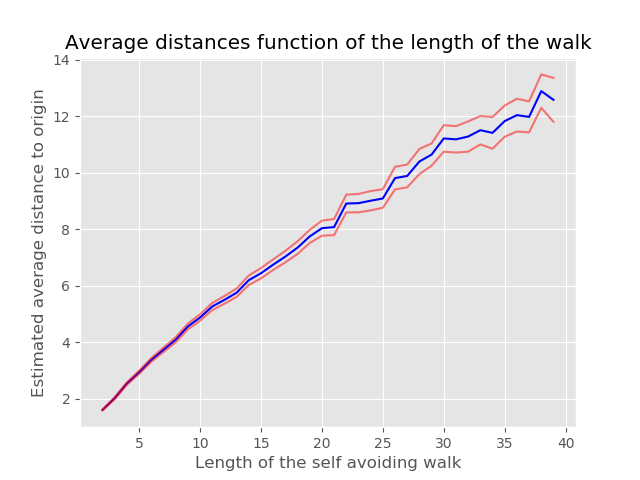

In [65]:
plot_estimator(mean_d_IS, l_max=40, n = 1000)

In [67]:
def is_maae(X):
    return np.unique(X, axis=0).shape[0] == X.shape[0]

In [68]:
def build_ma(n, l, d = 2):
    """
        Build n random walk of length l in d dimension
    """
    
    k = l+1 # Number of trajectory points
    directions = np.concatenate((np.identity(d), -np.identity(d))).astype(np.int8) # Possible movement

    # Generate MAs
    X = pick_random(directions, n*k) # Generate more because concatenation is more heavy
    X = X.cumsum(axis=0).reshape((n,k,d))
    X -= np.repeat(X[:,0,:] ,k, axis=0).reshape((n,k,d)) # Normalizing to (0,0)
    
    return X

In [71]:
X = build_ma(5, 5)
is_maae(X)

True

In [43]:
def build_maae_reject(n, l, d = 2):
    N_estimated = n**(1/(1 - 1/(d*2)))
    N_patch = min(10E5, N_estimated)
    
    X = build_ma(N_patch)

    #Check if is MAAE
    is_maae_mask = np.zeros((n), dtype = np.bool)
    for i, x in enumerate(X):
        is_maae_mask[i] = is_maae(x)

    X_maae = X[is_maae_mask]
    return X_maae

In [44]:
def true_generate(n, l, d = 2):
    walks = np.zeros((n, l+1, d))
    for i in range(n):
        init_walks = build_maae_reject(1, l, d)
        while init_walks.shape != (1, l+1, d):
            init_walks = build_maae_reject(1, l, d)
        walks[i] = init_walks[0]
    return walks

In [45]:
def mean_d_reject(l, n=10000, d = 2):
    D = np.zeros(n)
    m = true_generate(n, l, d = 2)
    for i in range(n):
        D[i] = dist(m[i])
        
    estimated_average_distance = np.mean(D)
    estimated_variance = np.var(D)
    return estimated_average_distance, estimated_variance

In [47]:
mean_d_reject(l, n = 100, d=2)

(1.6309545442950506, 0.07998727444332614)

In [48]:
T_reject = []
S_reject = []
compute_times_reject = []

for l in range(2,40):
    start = time.time()
    distance, var = mean_d_reject(l, n = 100, d=2)
    end = time.time()
    T_reject.append(distance)
    S_reject.append(var**0.5)
    compute_times_reject.append(end-start)
    
    
up_reject = [x + y for x, y in zip(T_reject, map(lambda x: x*1.96/(10000**0.5),S))]
down_reject = [x - y for x, y in zip(T_reject, map(lambda x: x*1.96/(10000**0.5),S))]
    
plt.figure()
plt.xlabel('Length of the self avoiding walk')
plt.ylabel('Estimated average distance to origin')
plt.plot(np.arange(2,40), T_reject)
plt.plot(np.arange(2,40), up_reject)
plt.plot(np.arange(2,40), down_reject)

KeyboardInterrupt: 

In [ ]:
plt.plot(T_reject)

In [ ]:
T_reject

In [ ]:
up_reject = [x + y for x, y in zip(T_reject, map(lambda x: x*1.96/(10000**0.5),S_reject))]
down_reject = [x - y for x, y in zip(T_reject, map(lambda x: x*1.96/(10000**0.5),S_reject))]
    
plt.figure()
plt.xlabel('Length of the self avoiding walk')
plt.ylabel('Estimated average distance to origin')
plt.plot(np.arange(2,17), T_reject, label='Algorithme rejet')
plt.plot(np.arange(2,17), up_reject)
plt.plot(np.arange(2,17), down_reject)
plt.plot(np.arange(2,17), T[:15], label='Algorithme IS')
plt.plot(np.arange(2,17), up[:15])
plt.plot(np.arange(2,17), down[:15])
plt.legend()

In [ ]:
est_var_reject = []
est_var_naive = []

for l in range(1, 11):
    Reject = []
    Naive = []
    for _ in range(100):
        Reject.append(mean_d_reject(l, n = 1000)[0])
        Naive.append(mean_d(l, n = 1000)[0])
    est_var_reject.append(np.var(Reject))
    est_var_naive.append(np.var(Naive))

In [ ]:
est_var_reject

In [ ]:
est_var_naive

In [ ]:
plt.figure()
plt.xlabel('Length of the self avoiding walk')
plt.ylabel('Estimated variance of estimator')
plt.plot(np.arange(1, 10), est_var_reject, label='Algorithme du rejet')
plt.plot(np.arange(1, 10), est_var_naive, label='Algorithme IS')
plt.legend()

In [ ]:
plt.figure()
plt.xlabel('Length of the self avoiding walk')
plt.ylabel('Time to compute average distance (s.)')
plt.plot(np.arange(2,17), compute_times_reject, label='Algorithme rejet')
plt.plot(np.arange(2,17), compute_times_naive[:15], label='Algorithme IS')
plt.legend()

In [ ]:
def reflex_sym(part_walk, angle):
    
    #starting point
    point = part_walk[0]
    
    #define the corresponding rotation matrix
    R = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])
    
    #start to set the origin at the starting point
    centered_walk = part_walk - point
    
    #apply rotation
    rotated_walk = np.dot(R, np.transpose(centered_walk))
    
    #dectenter
    final_walk = np.transpose(rotated_walk) + point
    
    return np.rint(final_walk)
    

In [ ]:
from copy import copy

In [ ]:
def maae_roation_sym(N, l):
    init_walk = true_generate(1, l, d=2)
    
    whole_walk_new = init_walk[0]
    
    start = time.time()
    
    for _ in range(N):
        
        k = np.random.choice(np.arange(l), 1)[0]

        part_walk = copy(whole_walk_new[k:])

        a = np.random.randint(2)

        if a == 0:
            new_part_walk = reflex_sym(part_walk, angle = np.pi/2)

        else:
            new_part_walk = reflex_sym(part_walk, angle = 3*np.pi/2)
        
        possible_walk_new = np.concatenate((whole_walk_new[:k], new_part_walk))

        if is_maae(possible_walk_new):
            whole_walk_new = possible_walk_new
            
    end = time.time()
    
    return whole_walk_new, end-start

In [ ]:
_, comp_time = maae_roation_sym(3000, l=30)
print(comp_time)

In [ ]:
start = time.time()
true_generate(n=1, l=30, d = 2)
end = time.time()
print(end-start)

In [ ]:
times_reject = []
times_rot = []

for l in range(1,30):

    _, comp_time = maae_roation_sym(6000, l=l)
    times_rot.append(comp_time)
    
    start = time.time()
    true_generate(n=1, l=l, d = 2)
    end = time.time()
    times_reject.append(end-start)
    
    print('Length '+str(l)+' checked.')

In [ ]:
plt.figure()
plt.plot(times_reject, label='Algorithme du rejet')
plt.plot(times_rot, label = 'Algorithme du pivot') #avec N=6000 transformations
plt.title('Comparaison temps d execution rejet/pivot')
plt.legend()

In [ ]:
plt.show